# Import

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory

# Data importeren

Importeren van de data uit drive,
vul de authorization code in die verkregen wordt via de link of er wordt al direct een scherm opgebracht waar je kan inloggen.

In [4]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Schilderijen-Classificeren_Arthur-Huys/datasets" "/content/datasets"

Mounted at /gdrive


In [5]:
import shutil
shutil.unpack_archive('datasets/Picasso_Rubens_400_100_100.zip','.','zip')

# creëren datasets

Bij het creëren van deze datasets moet de class_mode verandert naar categorical omdat we nu met multi class data werken (3 verschillende labels).

In [55]:
train_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/train",
    image_size=(224, 224),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/validation",
    image_size=(224, 224),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    "Picasso_Rubens_400_100_100/test",
    image_size=(224, 224),
    batch_size=32)

Found 800 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


# Building model

In [56]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    include_top=False, 
    weights="imagenet")

base_model.trainable = True
for layer in base_model.layers[:-12]:
  layer.trainable = False

In [57]:
data_augmentation = keras.Sequential(
    [layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
     layers.RandomContrast(0.5,1.5)])

In [58]:
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [59]:
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

# Training model

In [60]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.keras",
    save_best_only=True,
    monitor="val_loss")]

In [61]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8950

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


25/25 [==============================] - 197s 7s/step - loss: 0.3476 - accuracy: 0.8950 - val_loss: 0.2636 - val_accuracy: 0.9500
Epoch 2/10
25/25 [==============================] - 177s 7s/step - loss: 0.1236 - accuracy: 0.9638 - val_loss: 0.1270 - val_accuracy: 0.9800
Epoch 3/10
25/25 [==============================] - 176s 7s/step - loss: 0.1016 - accuracy: 0.9725 - val_loss: 0.0908 - val_accuracy: 0.9750
Epoch 4/10
25/25 [==============================] - 175s 7s/step - loss: 0.0353 - accuracy: 0.9862 - val_loss: 0.1023 - val_accuracy: 0.9700
Epoch 5/10
25/25 [==============================] - 175s 7s/step - loss: 0.0534 - accuracy: 0.9800 - val_loss: 0.0861 - val_accuracy: 0.9750
Epoch 6/10
25/25 [==============================] - 175s 7s/step - loss: 0.0349 - accuracy: 0.9875 - val_loss: 0.0884 - val_accuracy: 0.9800
Epoch 7/10
25/25 [==============================] - 175s 7s/step - loss: 0.0213 - accuracy: 0.9900 - val_loss: 0.0871 - val_accuracy: 0.9800
Epoch 8/10
25/25 [======

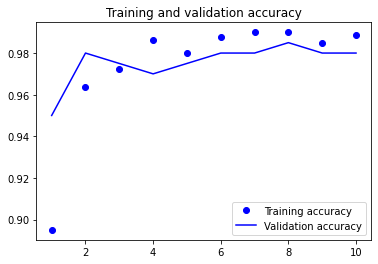

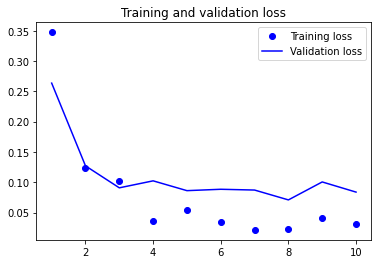

In [62]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Testing

Hier kunnen we weer zien dat de validation accuracy ongeveer gelijk blijf na de 40ste epoch.

In [63]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

7/7 [==============================] - 32s 4s/step - loss: 0.0200 - accuracy: 0.9950
Test accuracy: 0.995


In [65]:
test_model.save("model_two_painters.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
